## 基于收益预测模型的商家锁定营销敏感人群投放策略

本项目应用uplift模型来针对有效用户群体。
分析共计6400个客户数据的营销推广活动。

预测客户的转化率，提升建模以最大化营销活动并降低活动成本

增益模型（uplift model）定义：一种用于估算个体干预增量（uplift）的模型，即干预动作（treatment）对用户响应行为（outcome）产生的效果。

In [1]:
# Import libraries
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns, math, os, warnings
import pandas as pd
warnings.filterwarnings('ignore')
# Get file's directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
pd.set_option('Display.max_rows',None)#show all cols
pd.set_option('Display.max_columns',None)

增益模型（uplift model）定义：一种用于估算个体干预增量（uplift）的模型，即干预动作（treatment）对用户响应行为（outcome）产生的效果。


In [2]:
# 读取数据
df_data = pd.read_csv('customer_campaign.csv')
df_model = df_data.copy()

NameError: name 'pd' is not defined

In [1]:
df_model.head(5)

NameError: name 'df_model' is not defined

recency：自上次购买以来的月数

history：历史购买的金额

used_discount/used_bogo：表示客户是否使用折扣或买一送一

zip_code：邮政编码类别为郊区/城市/农村

is_referral：表示客户是否是从推荐渠道获得的

渠道：客户使用的渠道，电话/网络/多渠道

offer: 发送给客户的优惠，Discount/But One Get One/No Offer

In [5]:
# 查看缺失值
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [6]:
# 分类型查看
df_model.describe(include=np.object)

,zip_code,channel,offer
count,64000,64000,64000
unique,3,3,3
top,Surburban,Web,Buy One Get One
freq,28776,28217,21387


In [7]:
# 查看unique值
object_cols = [col for col in df_model.columns if df_model[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df_model[obj].unique():
        print("{} {}".format(unique,sum(df_model[obj] == unique)))


 zip_code
Surburban 28776
Rural 9563
Urban 25661

 channel
Phone 28021
Web 28217
Multichannel 7762

 offer
Buy One Get One 21387
No Offer 21306
Discount 21307


# 数据预处理 Data Preprocessing 

In [8]:
# 目标列
df_model = df_model.rename(columns={'conversion': 'target'})
# 做实验组标签
df_model = df_model.rename(columns={'offer': 'treatment'})
df_model.treatment = df_model.treatment.map({'No Offer': 0, 'Buy One Get One': -1, 'Discount': 1})

#### 数据特征处理

In [9]:
# One-Hot Encoding:
df_model = pd.get_dummies(df_model)

In [10]:
# 将数据集分为bogo和discount
df_model_bogo = df_model.copy().loc[df_model.treatment <=0].reset_index(drop=True)
df_model_discount = df_model.copy().loc[df_model.treatment >=0].reset_index(drop=True)

目标类别定义：
Control Non-Responders(CN)

只有领券才会进行购买的用户 (value = 0)


Control Responders(CR)

没有领券会进行购买的用户 (value = 1)


Treatment Non-Responders(TN)

领券后依然不会进行购买的用户 (value = 2)


Treatment Responders(TR)

领到券并进行购买的用户 (value = 3)

In [12]:
df_model_bogo.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,-1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,-1,0,0,1,0,0,0,1
3,2,45.34,1,0,0,-1,0,0,0,1,0,0,1
4,6,134.83,0,1,0,-1,1,0,1,0,0,1,0


In [11]:
df_model_discount.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,6,329.08,1,1,1,0,0,1,0,0,0,0,1
1,9,675.83,1,0,1,1,0,1,0,0,0,0,1
2,9,675.07,1,1,1,1,0,1,0,0,0,1,0
3,2,101.64,0,1,0,1,1,0,0,1,0,0,1
4,4,241.42,0,1,1,0,0,1,0,0,1,0,0


In [13]:
# 定义目标群体
def declare_tc(df:pd.DataFrame):
    """Declare target class
    """
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1 
    #TN:
    df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2 
    #TR:
    df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3 
    return df

In [14]:
df_model_bogo = declare_tc(df_model_bogo)
df_model_discount = declare_tc(df_model_discount)

In [15]:
# Uplift模型 
from sklearn.model_selection import train_test_split
import xgboost as xgb
def uplift_split(df_model:pd.DataFrame):
    """Train-Test Split
    """
    X = df_model.drop(['target','target_class'],axis=1)
    y = df_model.target_class
    X_train, X_test, \
    y_train, y_test  = train_test_split(X,
                                       y,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df_model['treatment'])
    return X_train,X_test, y_train, y_test


def uplift_model(X_train:pd.DataFrame,
                 X_test:pd.DataFrame,
                 y_train:pd.DataFrame,
                 y_test:pd.DataFrame):
    """Using XGB to get the uplift score
    """
    # Create new dataframe
    result = pd.DataFrame(X_test).copy()    
    # Fit the model
    uplift_model \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)
    
    
    # 验证集跑预测结果
    uplift_proba \
    = uplift_model.predict_proba(X_test.drop('treatment', axis=1))
    result['proba_CN'] = uplift_proba[:,0] 
    result['proba_CR'] = uplift_proba[:,1] 
    result['proba_TN'] = uplift_proba[:,2] 
    result['proba_TR'] = uplift_proba[:,3]
    result['uplift_score'] = result.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')   
    result['target_class'] = y_test
    return result


def uplift(df_model:pd.DataFrame):
    X_train, X_test, y_train, y_test = uplift_split(df_model)
    result = uplift_model(X_train, X_test, y_train, y_test)
    return result

In [16]:
# Run the uplift function
bogo_uplift = uplift(df_model_bogo)
discount_uplift = uplift(df_model_discount)

In [18]:
discount_uplift.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
1994,3,977.51,1,1,1,0,0,0,1,0,0,1,0.530432,0.144612,0.253953,0.071003,0.008549,0
42476,4,391.10,1,0,0,0,1,0,0,1,0,0,0.477415,0.059563,0.302406,0.160616,0.471927,0
24681,7,72.37,1,0,1,1,0,0,1,0,0,1,0.509015,0.013694,0.431812,0.045479,0.138176,2
9238,10,67.40,1,0,0,1,0,0,1,0,0,1,0.414192,0.079235,0.437376,0.069197,-0.047966,2
35847,2,45.68,1,0,1,1,0,0,1,0,1,0,0.457645,0.018638,0.473596,0.050122,0.113142,2


In [17]:
bogo_uplift.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
20765,10,211.48,1,0,0,0,0,1,0,1,0,0,0.623754,0.057602,0.273621,0.045023,0.113510,1
7222,10,140.50,1,0,0,-1,0,0,1,0,1,0,0.511970,0.019497,0.440900,0.027633,0.044586,2
6434,4,76.25,1,0,0,-1,0,1,0,0,1,0,0.468098,0.090066,0.381348,0.060488,-0.048920,2
32666,5,29.99,0,1,0,-1,1,0,0,0,1,0,0.461972,0.092152,0.331452,0.114424,0.180654,2
24212,9,248.28,1,0,0,-1,0,1,0,0,0,1,0.512261,0.076322,0.368803,0.042614,-0.052184,3


In [16]:
# Functions to build the Uplift model and visualize the QINI Curve
def qini_rank(uplift:pd.DataFrame):
    """Rank the data by the uplift score
    """
    # Creat new dataframe
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    
    
    # Add proportion
    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking   
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked


def qini_eval(ranked:pd.DataFrame):
    """Evaluate the uplift value with the QINI criterion
    """
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)
    
    
    # Add q0
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    return merged


def qini_plot(merged:pd.DataFrame):
    """Plot the QINI
    """
    # plot the data
    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])
    
    
    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=15)
    plt.ylabel('Uplift',fontsize=15)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=15)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax


def qini(uplift:pd.DataFrame):
    """Combine all functions
    """
    ranked = qini_rank(uplift)
    merged = qini_eval(ranked)
    ax = qini_plot(merged)
    return ax

# 用Qini曲线模拟模型表现

Text(0.5, 1.0, 'Qini Curve - Buy One Get One')

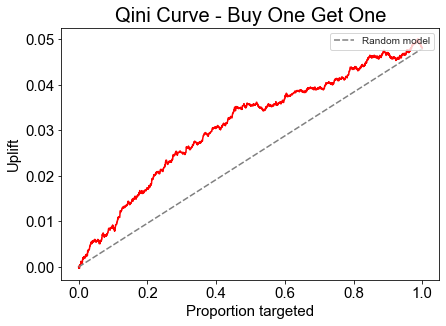

In [17]:
# 买一赠一组 - Qini曲线
qini(bogo_uplift)
plt.title('Qini Curve - Buy One Get One',fontsize=20)

Text(0.5, 1.0, 'Qini Curve - Discount')

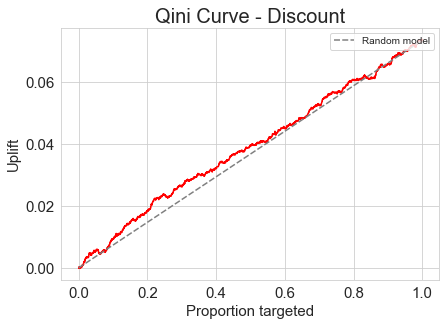

In [18]:
# 优惠券组 - Qini曲线
qini(discount_uplift)
plt.title('Qini Curve - Discount',fontsize=20)

In [19]:
# Functions for Uplift
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
# run the functions for each treatment
df_model_bogo = declare_tc(df_model_bogo)
df_model_discount = declare_tc(df_model_discount)

In [25]:
df = df_model_bogo
df1 = df_model_discount

In [28]:
 #CN:
df['target_class'] = 0 
    #CR:
df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1 
    #TN:
df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2 
    #TR:
df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3 


In [29]:
 #CN:
df1['target_class'] = 0 
    #CR:
df1.loc[(df1.treatment == 0) & (df1.target != 0),'target_class'] = 1 
    #TN:
df1.loc[(df1.treatment != 0) & (df1.target == 0),'target_class'] = 2 
    #TR:
df1.loc[(df1.treatment != 0) & (df1.target != 0),'target_class'] = 3 

In [27]:
df_model.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,-1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,-1,0,0,1,0,0,0,1
3,9,675.83,1,0,1,1,0,1,0,0,0,0,1
4,2,45.34,1,0,0,-1,0,0,0,1,0,0,1


In [33]:
X = df.drop(['target','target_class'],axis=1)
y = df.target_class

In [ ]:
X

In [ ]:
X_train, X_test, \
y_train, y_test  = train_test_split(X,y,test_size=0.3,
                                       random_state=42,
                                       stratify=df['treatment'])

In [37]:
    # Create new dataframe
result = pd.DataFrame(X_test).copy()    
    # Fit the model
uplift_model \
= xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)

In [38]:
# Predict using test-data
uplift_proba \
= uplift_model.predict_proba(X_test.drop('treatment', axis=1))
result['proba_CN'] = uplift_proba[:,0] 
result['proba_CR'] = uplift_proba[:,1] 
result['proba_TN'] = uplift_proba[:,2] 
result['proba_TR'] = uplift_proba[:,3]
result['uplift_score'] = result.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    # Put the result 
result['target_class'] = y_test

In [44]:
X_test.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
20765,10,211.48,1,0,0,0,0,1,0,1,0,0
7222,10,140.50,1,0,0,-1,0,0,1,0,1,0
6434,4,76.25,1,0,0,-1,0,1,0,0,1,0
32666,5,29.99,0,1,0,-1,1,0,0,0,1,0
24212,9,248.28,1,0,0,-1,0,1,0,0,0,1


In [36]:

    # Predict using test-data
    uplift_proba \
    = uplift_model.predict_proba(X_test.drop('treatment', axis=1))
    result['proba_CN'] = uplift_proba[:,0] 
    result['proba_CR'] = uplift_proba[:,1] 
    result['proba_TN'] = uplift_proba[:,2] 
    result['proba_TR'] = uplift_proba[:,3]
    result['uplift_score'] = result.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    # Put the result 
    result['target_class'] = y_test
    return result


def uplift(df_model:pd.DataFrame):
    """Combine the split and Modeling function
    """
    X_train, X_test, y_train, y_test = uplift_split(df_model)
    result = uplift_model(X_train, X_test, y_train, y_test)
    return result

IndentationError: expected an indented block (1367776734.py, line 16)